# Extract N2 first positive band from Gillies picket fence spectrum

Using the data provided online

In [3]:
%matplotlib notebook

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy import interpolate
from scipy import optimize
import pandas as pd
import seaborn as sns

plt.style.use('seaborn')

##### Two helper functions for binning/donwsampling data

In [5]:

def bin_array(b, y, lon = False, method='mean'):
    '''
    Downsample y by binning it, improving statistics. Every b
    elements of y will be averaged together to create a new array, y_b, 
    of length ny_b = ceil(len(y)/b). Binning starts at the end of the array, 
    so the first element of y_b may not represent exactly b samples of y.
    
    INPUTS:
    
      *  b       -- TYPE:int,       The number of rows to bin together
      *  y       -- TYPE:array(ny), The array to be binned
      
    OPTIONAL INPUTS:
    
      *  lon     -- TYPE:bool,      If True, 360-deg discontinuities will
                                    be removed before averaging (e.g., for
                                    longitude binning). (Default False)
      *  method  -- TYPE:str,       'mean': average over elements in a bin (default)
                                    'max': take maximum over elements (e.g., for quality flags)
                                    'min': take minimum over elements (e.g., for quality factor)
                                    
    OUTPUTS:
    
      *  y_b  -- TYPE:array(ny_b),  The binned array
      
    '''
    # To save time, return quickly if b==1
    if b==1:
        return y
    
    ny = len(y)
    ny_b = int(np.ceil(1.0*ny/b))
    y_b = np.zeros(ny_b, dtype=y.dtype)
    for i in range(0,ny_b): # bin from the end to the beginning.
        i_new   = ny_b-i-1
        i_start = ny-(i+1)*b
        i_stop  = ny-i*b
        
        # grab the samples to be binned
        if np.mod(ny,b)!=0 and i_new==0: # special case in case ny is not divisible by b
            y_samps = y[:i_stop]
        else: # grab 
            y_samps = y[i_start:i_stop]

        if lon:
            y_samps = fix_longitudes(y_samps, 180.)
            
        if all(np.isnan(y_samps)): # If all the values are nan, return nan
            if y_b.dtype == complex:
                y_b[i_new] = np.nan + 1j*np.nan
            else:
                y_b[i_new] = np.nan
        else:
            if method == 'mean':
                y_b[i_new] = np.nanmean(y_samps)
            elif method == 'max':
                y_b[i_new] = np.nanmax(y_samps)
            elif method == 'min':
                y_b[i_new] = np.nanmin(y_samps)
            else:
                raise Exception('Input method="%s" not recognized. Try "mean", "max", or "min"' % method)
        
    return y_b
    
    
def bin_image(b, I, method='mean'):
    '''
    Downsample a 2D image in altitude to improve statistics while
    degrading vertical resolution. Every b rows will be averaged together. 
    Binning starts at high altitudes, so the lower rows of I_b may not represent 
    exactly b rows of I.
    
    INPUTS:
    
      *  b           -- TYPE:int,                        The number of rows to bin together
      *  I           -- TYPE:array(ny,nx),   UNITS:arb.  The MIGHTI interferogram
      
    OPTIONAL INPUTS:
    
      *  method  -- TYPE:str,       'mean': average over elements in a bin (default)
                                    'max': take maximum over elements (e.g., for quality flags)
                                    'min': take minimum over elements (e.g., for quality factor)

    OUTPUTS:
    
      *  I_b         -- TYPE:array(ny_b,nx), UNITS:arb.  The binned MIGHTI interferogram
      
    '''
    
    # To save time, return quickly if b==1
    if b==1:
        return I
    
    ny,nx = np.shape(I)
    # Initial call to bin_array to see what the size of the new image will be
    tmp = bin_array(b, I[:,0])
    ny_b = len(tmp)
    
    # Bin the interfogram column by column
    I_b = np.zeros((ny_b,nx),dtype=I.dtype)
    for i in range(nx):
        I_b[:,i] = bin_array(b,I[:,i], method=method)
    return I_b



### Read N2(1P) spectra from two sources:
 - Simek (2014): Relevant to sprites
 - Vallance Jones (1974): Relevant to aurora

In [6]:
simek2014 = pd.read_csv('simek2014.csv',            header=None, index_col=0)
vj0 = pd.read_csv('vallance_jones_n21p_0.csv',      header=None, index_col=0)
vj0 = 0.7*vj0 # I didn't properly scale the y-axis when I digitized the plot
vj1 = pd.read_csv('vallance_jones_n21p_1.csv',      header=None, index_col=0)
vj = pd.concat((vj0, vj1.iloc[1:])) # Fix disagreement at cutoff between pages


<IPython.core.display.Javascript object>


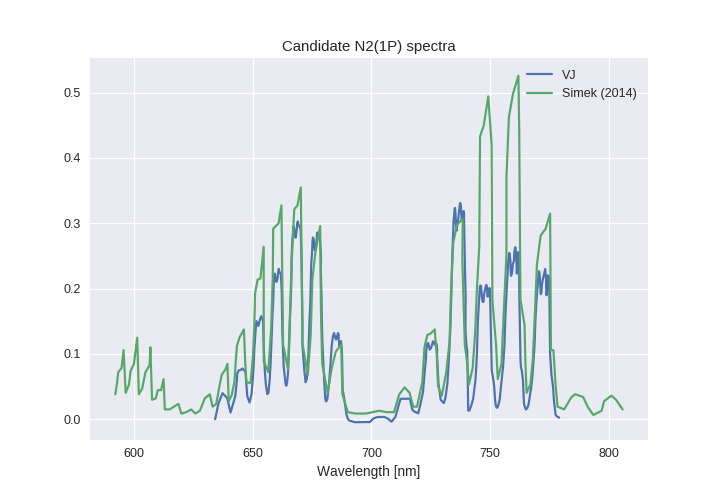

Text(0.5, 1.0, 'Candidate N2(1P) spectra')

In [7]:
plt.figure()
plt.plot(vj, label='VJ')
plt.plot(0.3*simek2014, label='Simek (2014)') # arbitrary scaling
plt.xlabel('Wavelength [nm]')
plt.legend()
plt.title('Candidate N2(1P) spectra')


### Read Gillies spectra

In [8]:
d = pd.read_csv('wavelength_per_bin.txt', header=None, skiprows=3, sep='[ \t\n]', engine='python')
lam = d.dropna(axis=1, how='all').values.ravel()[:-2]

d = pd.read_csv('TREx_spectrograph_20180410_063045.txt', header=None, skiprows=4, sep='[ \t\n]', engine='python')
d_green = d.stack().values.reshape(256,1024)

d = pd.read_csv('TREx_spectrograph_20180410_064015.txt', header=None, skiprows=4, sep='[ \t\n]', engine='python')
d_purple = d.stack().values.reshape(256,1024)

In [9]:
binning = 4 # Vertical binning by 4 to improve statistics
d_purple = bin_image(binning, d_purple.T).T
d_green  = bin_image(binning, d_green.T).T
lam      = bin_array(binning, lam)

In [10]:
print(d_purple.shape)
print(lam.shape)

(256, 256)
(256,)


<IPython.core.display.Javascript object>


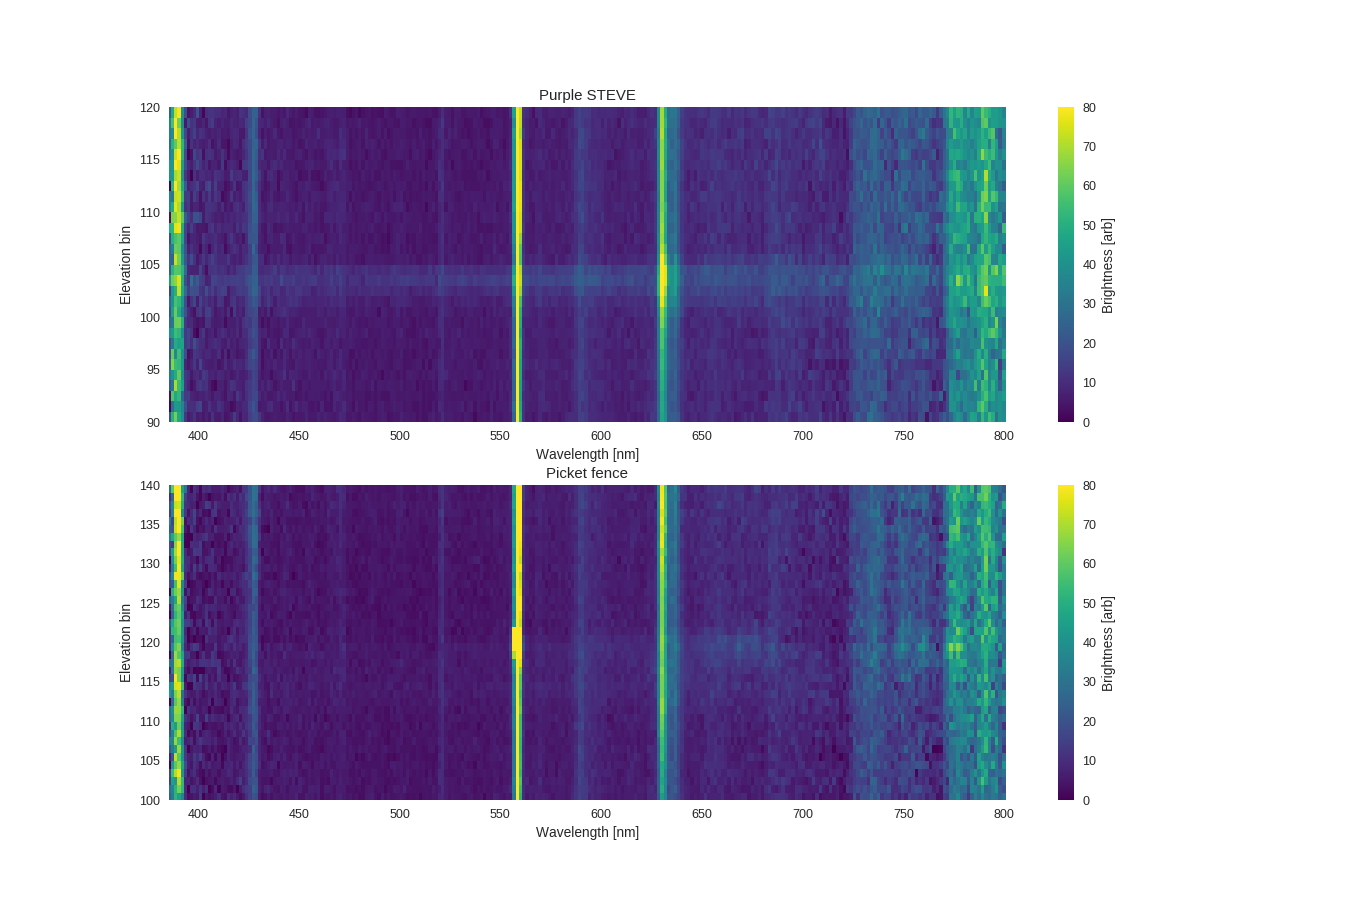

Text(0.5, 1.0, 'Picket fence')

In [11]:
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.pcolormesh(lam, np.arange(256), d_purple, cmap='viridis', vmin=0, vmax=80)
plt.colorbar(label='Brightness [arb]')
plt.xlabel('Wavelength [nm]')
plt.ylim((90,120))
plt.ylabel('Elevation bin')
plt.title('Purple STEVE')

plt.subplot(2,1,2)
plt.pcolormesh(lam, np.arange(256), d_green, cmap='viridis',vmin=0, vmax=80)
plt.xlabel('Wavelength [nm]')
plt.ylim((100,140))
plt.colorbar(label='Brightness [arb]')
plt.ylabel('Elevation bin')
plt.title('Picket fence')



# Read again for analysis

In [12]:
d = pd.read_csv('wavelength_per_bin.txt', header=None, skiprows=3, sep='[ \t\n]', engine='python')
lam = d.dropna(axis=1, how='all').values.ravel()[:-2]

d = pd.read_csv('TREx_spectrograph_20180410_063045.txt', header=None, skiprows=4, sep='[ \t\n]', engine='python')
d_green = d.stack().values.reshape(256,1024)

d = pd.read_csv('TREx_spectrograph_20180410_064015.txt', header=None, skiprows=4, sep='[ \t\n]', engine='python')
d_purple = d.stack().values.reshape(256,1024)

binning = 1 # No binning for this analysis
d_purple = bin_image(binning, d_purple.T).T
d_green  = bin_image(binning, d_green.T).T
lam      = bin_array(binning, lam)

In [13]:
y_g = np.mean(d_green, axis=1)
y_p = np.mean(d_purple, axis=1)

#### Identifying the location of the picket fence and background emission

In [14]:
ionp = 103
ioffp = [99,107]

iong = 119
ioffg = [116, 122]

<IPython.core.display.Javascript object>


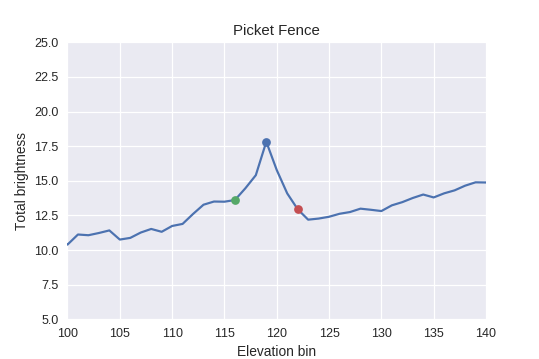

Text(0, 0.5, 'Total brightness')

In [15]:
plt.figure(figsize=(6,4))

plt.plot(y_g)
plt.plot(iong, y_g[iong], 'C0o')
for i in ioffg:
    plt.plot(i, y_g[i], 'o')
plt.xlim((100,140))
plt.ylim((5,25))
plt.xlabel('Elevation bin')
plt.title('Picket Fence')
plt.ylabel('Total brightness')

#### Recreate Gillies et al (2019) Figs 1 and 2

<IPython.core.display.Javascript object>


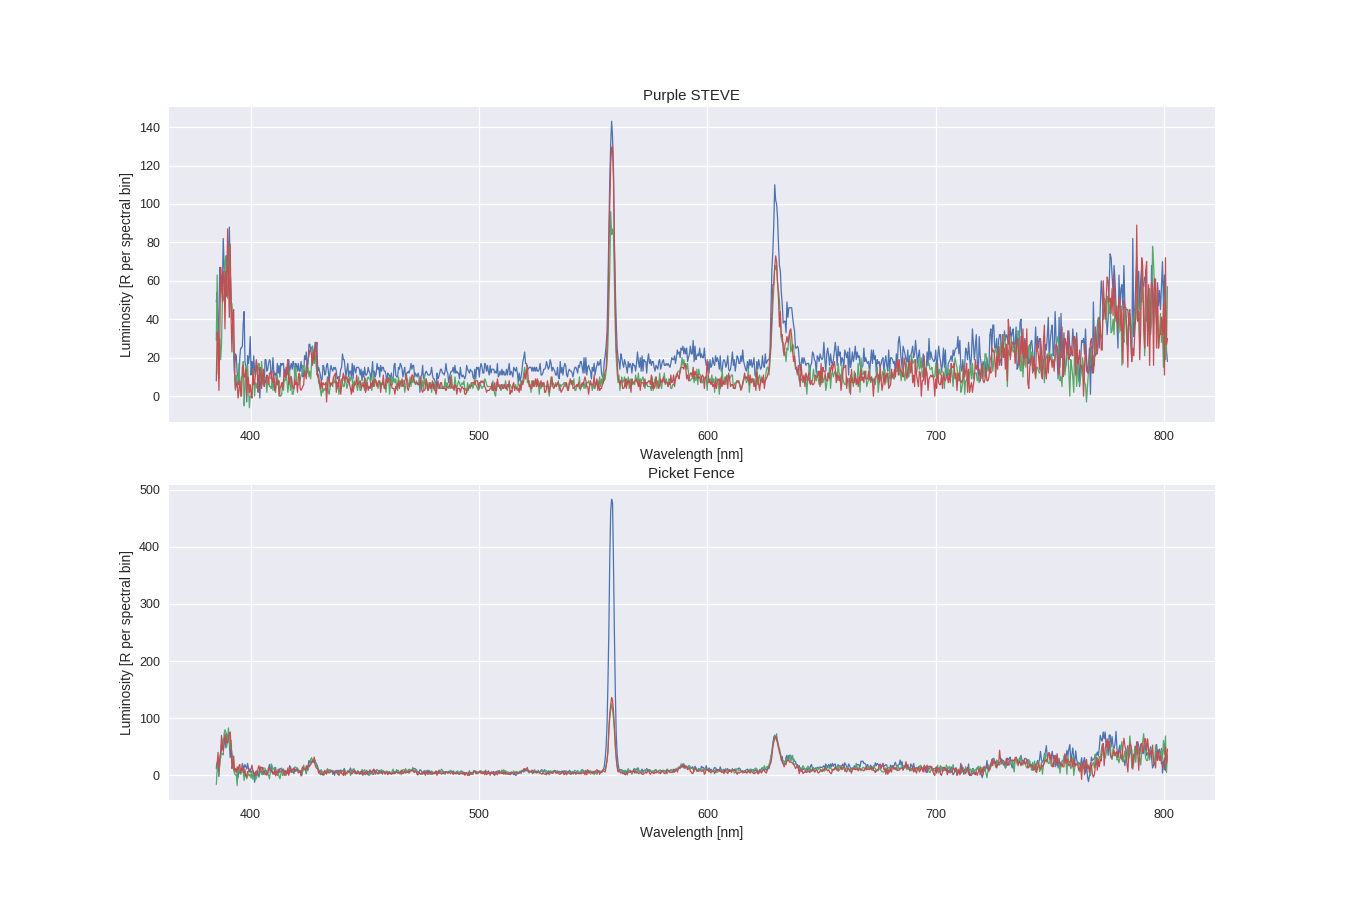

Text(0.5, 1.0, 'Picket Fence')

In [16]:
plt.figure(figsize=(15,10))
lw = 1

plt.subplot(2,1,1)
plt.plot(lam, d_purple[ionp,:], lw=lw)
for i in ioffp:
    plt.plot(lam, d_purple[i,:], lw=lw)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Luminosity [R per spectral bin]')
plt.title('Purple STEVE')

plt.subplot(2,1,2)
plt.plot(lam, d_green[iong,:], lw=lw)
for i in ioffg:
    plt.plot(lam, d_green[i,:], lw=lw)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Luminosity [R per spectral bin]')
plt.title('Picket Fence')

In [17]:
d0 = pd.Series(index = lam, data = d_green[ioffg,:].mean(axis=0)) # Average of background channels
d1 = pd.Series(index = lam, data = d_green[iong,:])

<IPython.core.display.Javascript object>


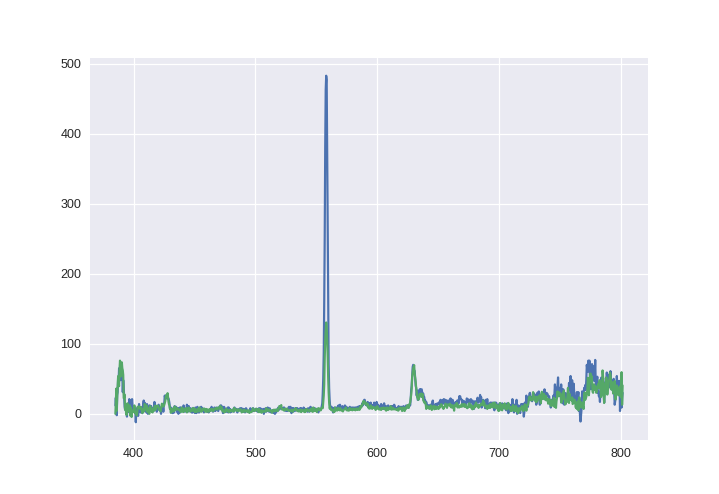

In [18]:
plt.figure()
plt.plot(d1)
plt.plot(d0)

In [19]:
lam = d0.index # Use Gillies raw wavelengths

dfs = pd.DataFrame(index=lam, data= {
                                    'steve+bg' : d1.values,
                                    'bg'       : d0.values,
#                                     'simek2014' : interpolate.interp1d(simek2014.index, simek2014.values[:,0], kind='linear', fill_value=0.0, bounds_error=False)(lam),
                                    'vj'       : interpolate.interp1d(vj.index, vj.values[:,0], kind='linear', fill_value=0.0, bounds_error=False)(lam),
})
  
# Cut wavelength range to 625-760
dfs_full = dfs.copy()
dfs = dfs[(dfs.index>=625) & (dfs.index<=760)]
dfs['steve'] = dfs['steve+bg'] - dfs['bg']

# vj_sc = dfs['steve'].mean()/dfs['vj'].mean()
vj_sc = (dfs['steve']*dfs['vj']).sum()/(dfs['vj']**2).sum() # this minimizes chi^2, analytically
vj_sc

32.729229583843534

In [20]:
# Rolling boxcar average over wavelength, to improve statistics and align with Vallance Jones resolution
b = 4
# dfs2 = pd.DataFrame(index = bin_array(b, dfs.index), data = bin_image(b, dfs.values), columns=dfs.columns)
dfs2 = dfs.rolling(b, center=True).mean()
dfs2 = dfs2.dropna()

dfs2_full = dfs_full.rolling(b, center=True).mean()
dfs2_full = dfs2_full.dropna()

<IPython.core.display.Javascript object>


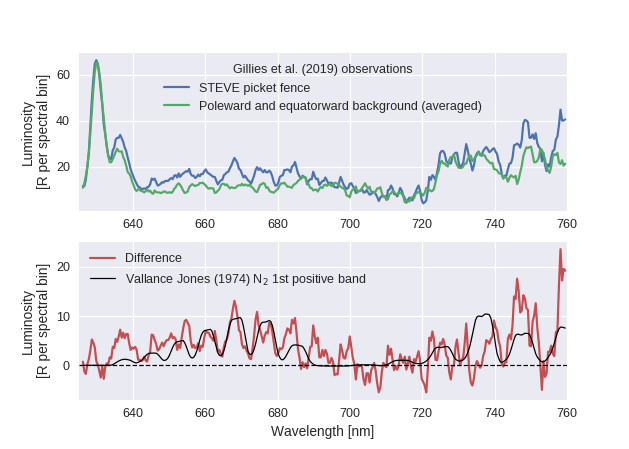

(625, 760)

In [21]:
plt.figure(figsize=(7,5))
plt.subplot(2,1,1)
plt.plot(dfs2['steve+bg'],'C0-', label='STEVE picket fence')
plt.plot(dfs2['bg'],'C1-', label='Poleward and equatorward background (averaged)')
plt.ylabel('Luminosity\n[R per spectral bin]')
plt.legend(title='Gillies et al. (2019) observations')
plt.xlim(625,760)

plt.subplot(2,1,2)
plt.plot(dfs2['steve'],'C2-', label='Difference')
plt.plot(vj_sc*dfs2['vj'],'k-',lw=1, label='Vallance Jones (1974) N$_2$ 1st positive band')
plt.plot([625, 760], [0,0], 'k--', lw=1)
plt.ylabel('Luminosity\n[R per spectral bin]')
plt.xlabel('Wavelength [nm]')
plt.legend()
plt.xlim(625,760)



### Final plot for Mende et al. (2019) paper

<IPython.core.display.Javascript object>


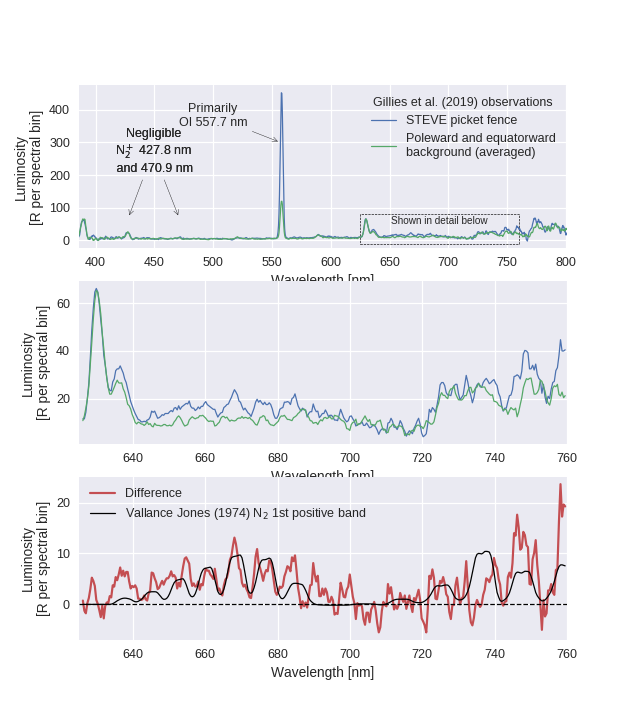

(625, 760)

In [22]:
import matplotlib.patches as patches

plt.figure(figsize=(7,8))

plt.subplot(3,1,1)
plt.plot(dfs2_full['steve+bg'],'C0-', lw=1, label='STEVE picket fence')
plt.plot(dfs2_full['bg'],'C1-', lw=1, label='Poleward and equatorward\nbackground (averaged)')
plt.ylabel('Luminosity\n[R per spectral bin]')
plt.legend(title='Gillies et al. (2019) observations')
plt.xlabel('Wavelength [nm]')
x0 = 625
x1 = 760
y0 = -10
y1 = 80
plt.gca().add_patch(patches.Rectangle((x0,y0),x1-x0,y1-y0, linewidth=0.5, color='k', linestyle='--', fill=False))
plt.text((x0+x1)/2, y1-5, 'Shown in detail below', ha='center', va='top', fontsize=8)
plt.xlim((dfs2_full.index[0], dfs2_full.index[-1]))

plt.annotate('Primarily\nOI 557.7 nm', (557, 300), xytext=(500,350), ha='center', arrowprops={'arrowstyle':'->'}, fontsize=10)
plt.annotate('Negligible\nN$_2^+$ 427.8 nm\n and 470.9 nm', (428, 70), xytext=(449,200), va='bottom', ha='center', arrowprops={'arrowstyle':'->'}, fontsize=10)
plt.annotate('Negligible\nN$_2^+$ 427.8 nm\n and 470.9 nm', (471, 70), xytext=(449,200), va='bottom', ha='center', arrowprops={'arrowstyle':'->'}, fontsize=10)

plt.subplot(3,1,2)
plt.plot(dfs2['steve+bg'],'C0-', lw=1, label='STEVE picket fence')
plt.plot(dfs2['bg'],'C1-', lw=1, label='Poleward and equatorward\nbackground (averaged)')
plt.ylabel('Luminosity\n[R per spectral bin]')
# plt.legend(title='Gillies et al. (2019) observations')
plt.xlim(625,760)
plt.xlabel('Wavelength [nm]')

plt.subplot(3,1,3)
plt.plot(dfs2['steve'],'C2-', label='Difference')
plt.plot(vj_sc*dfs2['vj'],'k-',lw=1, label=r'Vallance Jones (1974) N$_2$ 1st positive band')
plt.plot([625, 760], [0,0], 'k--', lw=1)
plt.ylabel('Luminosity\n[R per spectral bin]')
plt.xlabel('Wavelength [nm]')
plt.legend()
plt.xlim(625,760)


<IPython.core.display.Javascript object>


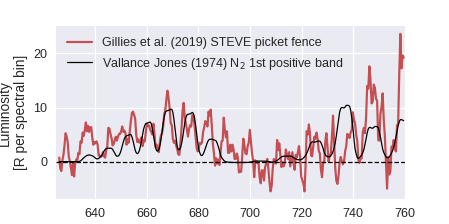

(625, 760)

In [23]:
plt.figure(figsize=(5,2.5))

plt.plot(dfs2['steve'],'C2-', label='Gillies et al. (2019) STEVE picket fence')
plt.plot(vj_sc*dfs2['vj'],'k-',lw=1, label='Vallance Jones (1974) N$_2$ 1st positive band')
plt.plot([625, 760], [0,0], 'k--', lw=1)
plt.ylabel('Luminosity\n[R per spectral bin]')
plt.xlabel('Wavelength [nm]')
plt.legend()
plt.xlim(625,760)


# Calculate intensity ratios
#### Note this only accounts for N2(1P) emissions between ~630 - 780 nm (i.e., Δv = +4 and +3 bands) and thus misses a non-negligible amount of N2(1P) emission

In [24]:
dfs = pd.DataFrame(index=d0.index, data= {
                                    'steve+bg' : d1.values,
                                    'bg'       : d0.values,
                                    'vj'       : 50*interpolate.interp1d(vj.index, vj.values[:,0], kind='linear', fill_value=0.0, bounds_error=False)(d0.index), # arbitrary scaling
})

# Rolling boxcar average over wavelength
b = 4
# dfs2 = pd.DataFrame(index = bin_array(b, dfs.index), data = bin_image(b, dfs.values), columns=dfs.columns)
dfs = dfs.rolling(b, center=True).mean()
dfs = dfs.dropna()

# dfs = dfs[dfs.index < 760.] # Limit wavelength range

<IPython.core.display.Javascript object>


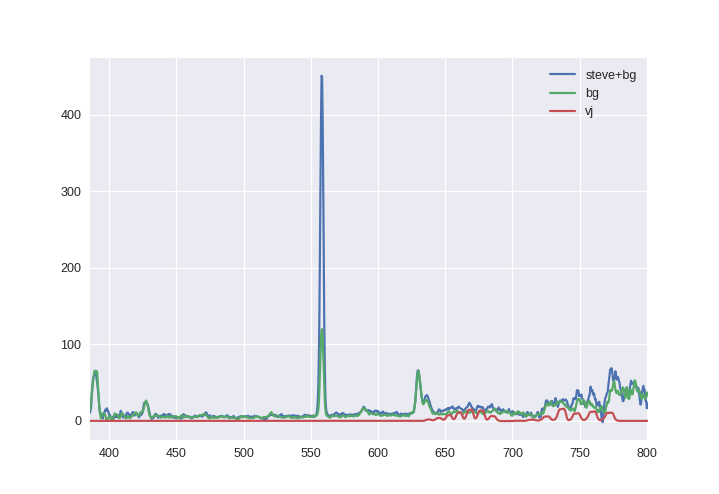

In [25]:
dfs.plot()

In [26]:
dfs['steve'] = dfs['steve+bg'] - dfs['bg']
vj_sc = (dfs['steve']*dfs['vj']).sum()/(dfs['vj']**2).sum() # this minimizes chi^2, analytically
dfs['vj'] = dfs['vj'] * vj_sc # Scale VJ spectrum to match the data

<IPython.core.display.Javascript object>


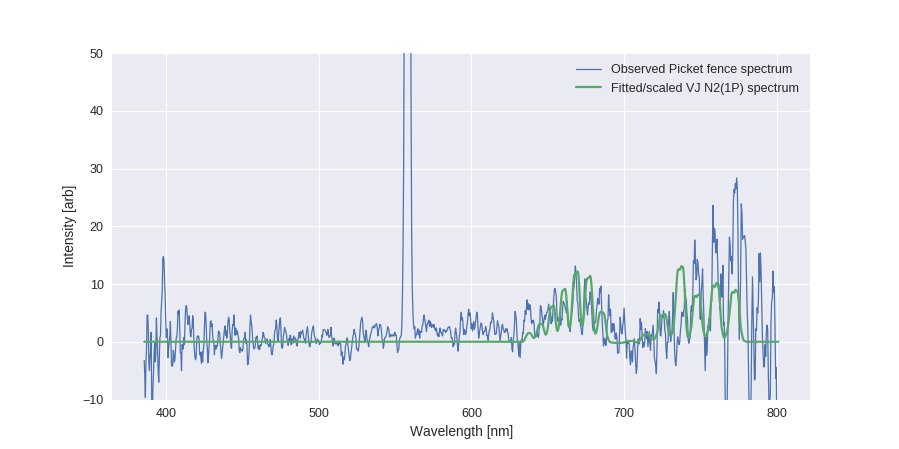

(-10, 50)

In [27]:
plt.figure(figsize=(10,5))
plt.plot(dfs['steve'], label='Observed Picket fence spectrum', lw=1)
plt.plot(dfs['vj'], label='Fitted/scaled VJ N2(1P) spectrum')
plt.legend()
plt.xlabel('Wavelength [nm]')
plt.ylabel('Intensity [arb]')
plt.ylim((-10,50))

In [28]:
dfs

,steve+bg,bg,vj,steve
385.745,10.75,14.000,0.000000e+00,-3.250
386.124,14.50,20.375,0.000000e+00,-5.875
386.504,16.50,26.125,0.000000e+00,-9.625
386.884,27.00,30.625,0.000000e+00,-3.625
387.264,39.00,40.375,0.000000e+00,-1.375
387.645,48.50,43.875,0.000000e+00,4.625
388.025,54.75,50.125,0.000000e+00,4.625
388.405,58.25,55.625,0.000000e+00,2.625
388.785,58.75,62.250,0.000000e+00,-3.500
389.165,60.75,65.750,0.000000e+00,-5.000


In [29]:
print('Total observed greenline 557.7 nm emission: %.0f R' % (dfs['steve'].loc[553.:563].sum()))
print('Total observed radiance 630-780 nm:         %.0f R' % (dfs['steve'].loc[630.:780.].sum()))
print('Total fitted N2(1P) radiance 630-780 nm:    %.0f R' % (dfs['vj'].sum()))
print('')
print('Fitted N2(1P) (630-780nm) to Green ratio:  %.2f' %  ((dfs['vj'].sum()) / (dfs['steve'].loc[553.:563].sum())))

Total observed greenline 557.7 nm emission: 2364 R
Total observed radiance 630-780 nm:         1716 R
Total fitted N2(1P) radiance 630-780 nm:    1390 R

Fitted N2(1P) (630-780nm) to Green ratio:  0.59


### N2(1P) spectrum from Simek (2014)

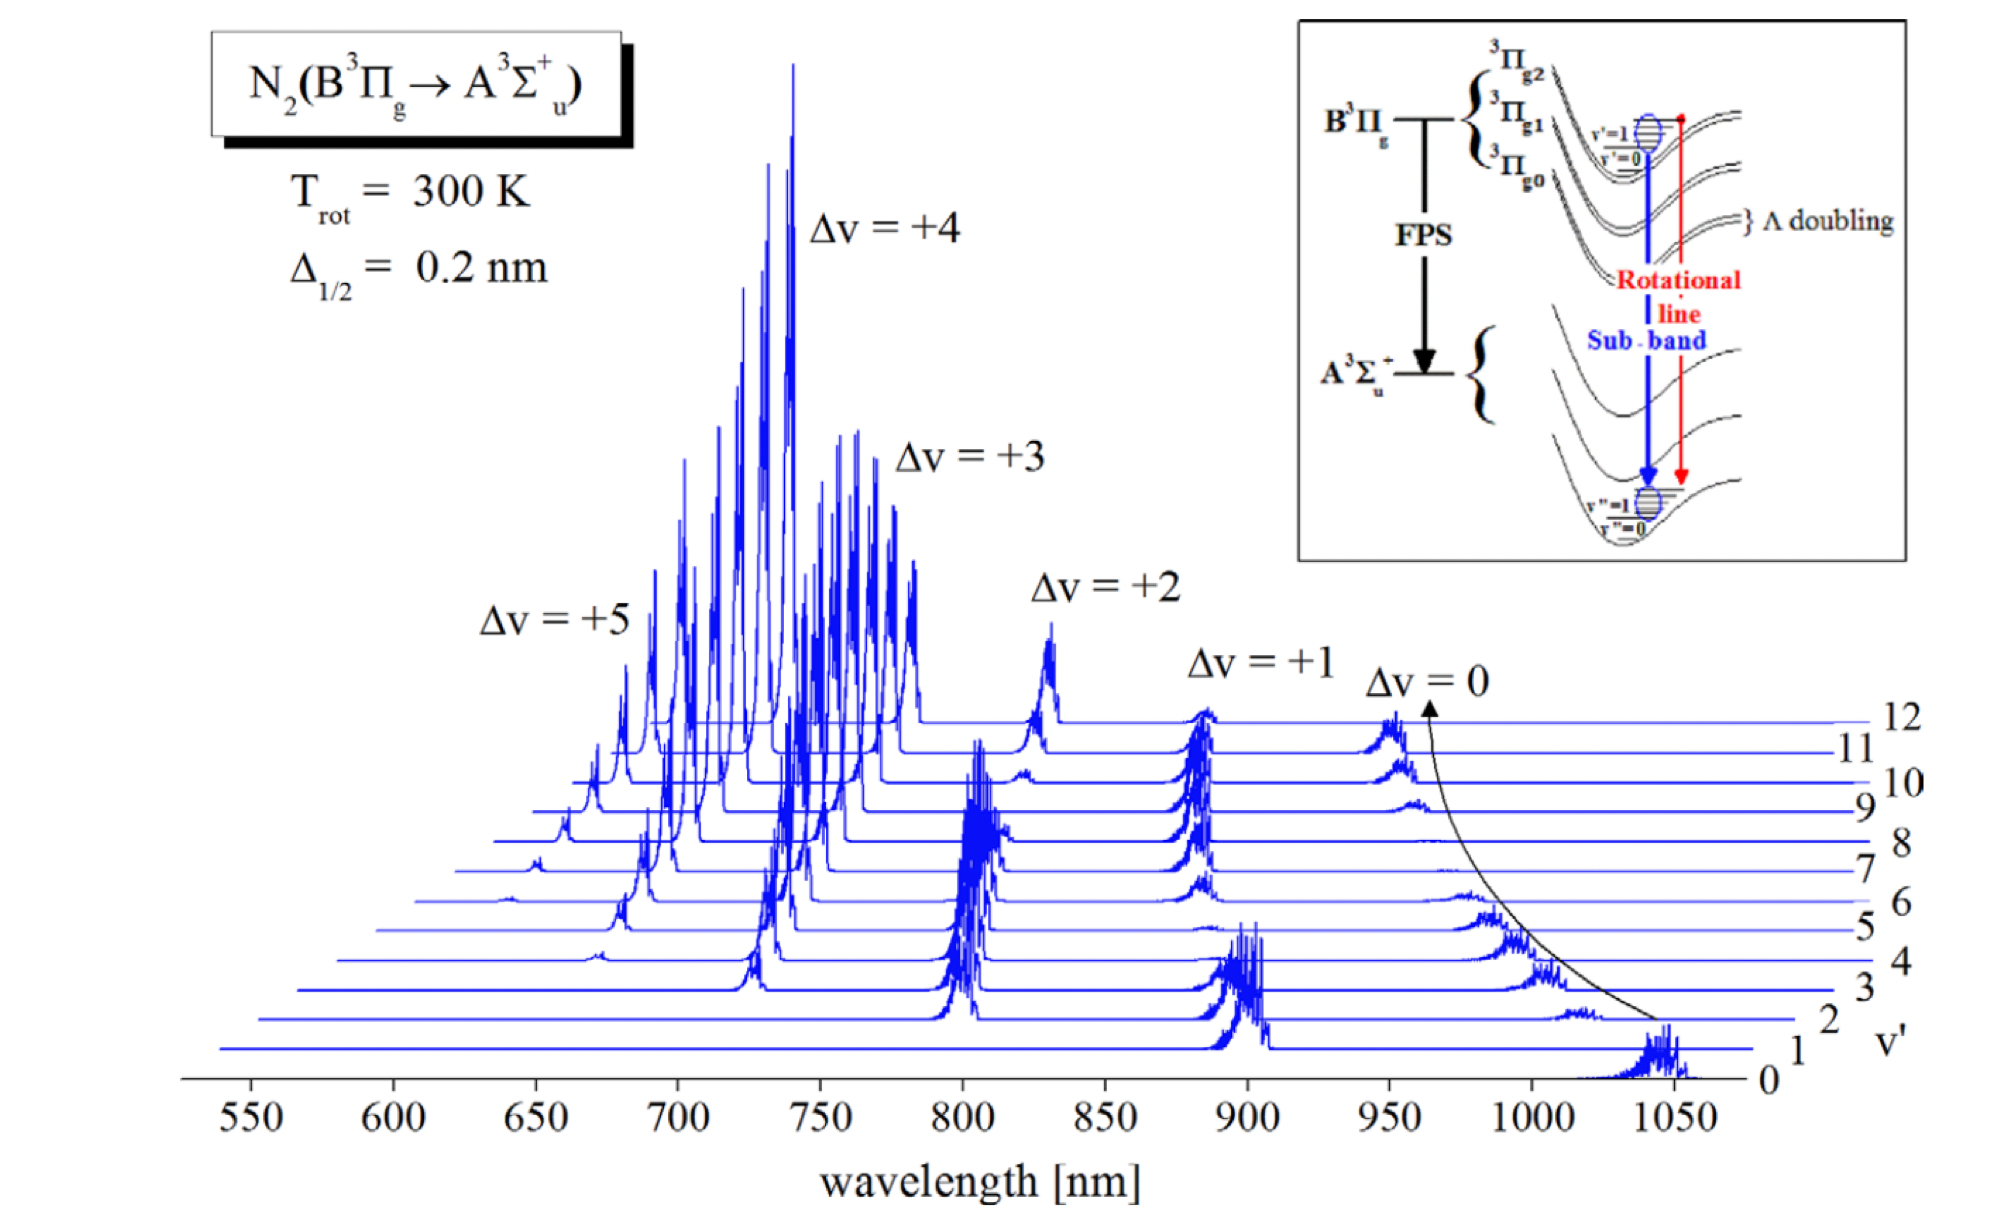